<a href="https://colab.research.google.com/github/Mrsayem/Multidataset-breast-ultrasound-image-segmentation/blob/main/HybridResnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Environment Setup**

In [ ]:
import random
import numpy as np
import torch
import os


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
os.environ['PYTHONHASHSEED'] = str(seed)

**Dataset loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, glob, random
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image


img_dir = '/content/drive/MyDrive/BUS-UCLM/images/'
mask_dir = '/content/drive/MyDrive/BUS-UCLM/masks/'

mask_files = set(os.listdir(mask_dir))

problematic = [
    'SIBA_001 (1).png',
    'STSP_000 (1).png',
    'SIBA_005 (1).png',
    'SIBA_008 (1).png',
    'SIBA_002 (1).png'
]

for fname in problematic:
    img_path = os.path.join(img_dir, fname)
    if not os.path.isfile(img_path):
        print(f"Image file not found (already handled?): {fname}")
        continue
    # Compute normalized name
    name, ext = os.path.splitext(fname)
    normalized = name.replace(' (1)', '') + ext  # e.g., 'SIBA_001.png'
    norm_path = os.path.join(img_dir, normalized)
    if os.path.isfile(norm_path):
        # If normalized already exists, drop the duplicate
        print(f"Deleting duplicate image {fname} because {normalized} exists.")
        os.remove(img_path)
    else:
        # Rename to normalized so mask lookup will match
        print(f"Renaming image {fname} → {normalized}")
        os.rename(img_path, norm_path)



all_imgs = sorted(glob.glob(os.path.join(img_dir, '*.png')))
all_masks = sorted(glob.glob(os.path.join(mask_dir, '*.png')))


def get_patient_id(path):
    fname = os.path.basename(path)
    return fname.split('_')[0]


patient_ids = sorted(set(get_patient_id(p) for p in all_imgs))
print(f"Total patients: {len(patient_ids)}")  # 38 patient



patient_ids = patient_ids.copy()
random.shuffle(patient_ids)
n = len(patient_ids)
train_ids = patient_ids[:int(0.70*n)]
val_ids   = patient_ids[int(0.70*n):int(0.85*n)]
test_ids  = patient_ids[int(0.85*n):]


patient_labels = {}

for mask_path in all_masks:
    pid = get_patient_id(mask_path)


    mask = np.array(Image.open(mask_path))


    has_malignant = np.any(
        (mask[:, :, 0] == 255) &
        (mask[:, :, 1] ==   0) &
        (mask[:, :, 2] ==   0)
    )

    has_benign = np.any(
        (mask[:, :, 0] ==   0) &
        (mask[:, :, 1] == 255) &
        (mask[:, :, 2] ==   0)
    )

    if has_malignant:
        patient_labels[pid] = 2
    elif has_benign:
        patient_labels[pid] = 1
    else:
        patient_labels[pid] = 0


patient_ids = list(patient_labels.keys())
labels = [patient_labels[pid] for pid in patient_ids]


train_ids, temp_ids = train_test_split(
    patient_ids,
    test_size=0.3,
    stratify=labels,
    random_state=42
)


temp_labels = [patient_labels[pid] for pid in temp_ids]


val_ids, test_ids = train_test_split(
    temp_ids,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

malignant_patients = [pid for pid in patient_ids if patient_labels[pid] == 2]
print(f"Total malignant patients: {len(malignant_patients)}")

# Identify malignant patients in training set
malignant_train_patients = [pid for pid in train_ids if patient_labels[pid] == 2]
print(f"Malignant patients in train before adjustment: {len(malignant_train_patients)}")
print(f"Malignant patients in test before adjustment: {len([pid for pid in test_ids if patient_labels[pid]==2])}")

# Move 2 malignant patients from train to test (random but fixed seed)
if len(malignant_train_patients) >= 2:
    random.seed(42)  # For reproducibility
    to_move = random.sample(malignant_train_patients, 2)

    print(f"\nMoving 2 malignant patients to test set: {to_move}")
    for pid in to_move:
        # Count images for this patient
        patient_images = [img for img in all_imgs if get_patient_id(img) == pid]
        print(f"  Patient {pid} has {len(patient_images)} images")

    # Update patient ID lists
    train_ids = [pid for pid in train_ids if pid not in to_move]
    test_ids.extend(to_move)  # Add to test set


train_imgs = [img for img in all_imgs if get_patient_id(img) in train_ids]
val_imgs = [img for img in all_imgs if get_patient_id(img) in val_ids]
test_imgs = [img for img in all_imgs if get_patient_id(img) in test_ids]

# Rebuild mask lists
train_masks = [os.path.join(mask_dir, os.path.basename(p)) for p in train_imgs]
val_masks = [os.path.join(mask_dir, os.path.basename(p)) for p in val_imgs]
test_masks = [os.path.join(mask_dir, os.path.basename(p)) for p in test_imgs]

#original BUS-UCLM splits
bus_uclm_train_imgs = train_imgs
bus_uclm_val_imgs = val_imgs
bus_uclm_test_imgs = test_imgs
bus_uclm_train_masks = train_masks
bus_uclm_val_masks = val_masks
bus_uclm_test_masks = test_masks

busi_extract_dir = '/content/drive/MyDrive/Curated_BUSI'
busi_mask_dir = '/content/BUSI_masks_combined'
os.makedirs(busi_mask_dir, exist_ok=True)

busi_imgs = []
busi_masks = []
busi_patients = []  # Patient IDs
busi_labels = []     # 0=normal, 1=benign, 2=malignant


image_dir = os.path.join(busi_extract_dir, 'images')
mask_dir = os.path.join(busi_extract_dir, 'masks')


image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.png')]
print(f"Found {len(image_files)} images")

for img_file in image_files:
    # Extract base name and class from filename
    base_name = os.path.splitext(img_file)[0]

    # Determine class from filename
    if 'benign' in base_name.lower():
        label = 1
        class_folder = 'benign'
    elif 'malignant' in base_name.lower():
        label = 2
        class_folder = 'malignant'
    elif 'normal' in base_name.lower():
        label = 0
        class_folder = 'normal'
    else:
        print(f"Warning: Could not determine class for {img_file}. Skipping.")
        continue

    img_path = os.path.join(image_dir, img_file)

    # unique patient ID
    patient_number = base_name.split('(')[-1].split(')')[0].strip()
    patient_id = f"BUSI_{class_folder}_{patient_number}"

    img = Image.open(img_path)
    combined_mask = np.zeros((img.height, img.width, 3), dtype=np.uint8)


    mask_patterns = [
        # Pattern for "benign (155)_mask.png"
        os.path.join(mask_dir, f"{base_name}_mask.png"),
        # Pattern for "benign (155) mask.png" (with space)
        os.path.join(mask_dir, f"{base_name} mask.png"),
        # Pattern for cases where mask might have a number suffix
        os.path.join(mask_dir, f"{base_name}_mask_*.png"),
        os.path.join(mask_dir, f"{base_name} mask_*.png"),
    ]

    mask_files = []
    for pattern in mask_patterns:
        mask_files.extend(glob.glob(pattern))

    # Remove duplicates and sort
    mask_files = sorted(list(set(mask_files)))


    if not mask_files:
        all_mask_files = [f for f in os.listdir(mask_dir)
                         if f.lower().endswith('.png') and 'mask' in f.lower()]

        # Look for masks that match the base name (number part)
        for mask_file in all_mask_files:
            if patient_number in mask_file:
                mask_files.append(os.path.join(mask_dir, mask_file))

    # Process masks for non-normal cases
    if label != 0 and mask_files:
        color = (0, 255, 0) if label == 1 else (255, 0, 0)  # Green for benign, red for malignant

        for mask_file in mask_files:
            try:
                mask = Image.open(mask_file).convert('L')
                mask_arr = (np.array(mask) > 0).astype(np.uint8) * 255

                # Add to combined mask
                for c in range(3):
                    combined_mask[:, :, c] = np.where(
                        mask_arr == 255,
                        color[c],
                        combined_mask[:, :, c]
                    )
            except Exception as e:
                print(f"Error processing {mask_file}: {str(e)}")
    elif label != 0 and not mask_files:
        print(f"Warning: No mask found for {img_file}")

    # Save mask with unique patient ID
    mask_save_path = os.path.join(busi_mask_dir, f"{patient_id}_mask.png")
    Image.fromarray(combined_mask).save(mask_save_path)

    busi_imgs.append(img_path)
    busi_masks.append(mask_save_path)
    busi_patients.append(patient_id)
    busi_labels.append(label)


if len(busi_patients) > 0:
    busi_train, busi_temp, busi_train_labels, busi_temp_labels = train_test_split(
        busi_patients, busi_labels, test_size=0.3, stratify=busi_labels, random_state=42
    )
    busi_val, busi_test, busi_val_labels, busi_test_labels = train_test_split(
        busi_temp, busi_temp_labels, test_size=0.5, stratify=busi_temp_labels, random_state=42
    )

    # Create BUSI image lists for each split
    busi_train_imgs = [img for img, pid in zip(busi_imgs, busi_patients) if pid in busi_train]
    busi_train_masks = [mask for mask, pid in zip(busi_masks, busi_patients) if pid in busi_train]
    busi_val_imgs = [img for img, pid in zip(busi_imgs, busi_patients) if pid in busi_val]
    busi_val_masks = [mask for mask, pid in zip(busi_masks, busi_patients) if pid in busi_val]
    busi_test_imgs = [img for img, pid in zip(busi_imgs, busi_patients) if pid in busi_test]
    busi_test_masks = [mask for mask, pid in zip(busi_masks, busi_patients) if pid in busi_test]
else:
    # Fallback if no BUSI images found
    busi_train_imgs, busi_train_masks = [], []
    busi_val_imgs, busi_val_masks = [], []
    busi_test_imgs, busi_test_masks = [], []
    print("No BUSI images processed - check paths and extraction")

# Combine with BUS-UCLM datasets
train_imgs = bus_uclm_train_imgs + busi_train_imgs
train_masks = bus_uclm_train_masks + busi_train_masks
val_imgs = bus_uclm_val_imgs + busi_val_imgs
val_masks = bus_uclm_val_masks + busi_val_masks
test_imgs = bus_uclm_test_imgs + busi_test_imgs
test_masks = bus_uclm_test_masks + busi_test_masks

#shuffle start
train_combined = list(zip(train_imgs, train_masks))
random.shuffle(train_combined)
train_imgs, train_masks = zip(*train_combined)
val_combined = list(zip(val_imgs, val_masks))
random.shuffle(val_combined)
val_imgs, val_masks = zip(*val_combined)
# Convert back to lists
train_imgs = list(train_imgs)
train_masks = list(train_masks)
val_imgs = list(val_imgs)
val_masks = list(val_masks)

Mounted at /content/drive
Image file not found (already handled?): SIBA_001 (1).png
Image file not found (already handled?): STSP_000 (1).png
Image file not found (already handled?): SIBA_005 (1).png
Image file not found (already handled?): SIBA_008 (1).png
Image file not found (already handled?): SIBA_002 (1).png
Total patients: 38
Total malignant patients: 9
Malignant patients in train before adjustment: 6
Malignant patients in test before adjustment: 1

Moving 2 malignant patients to test set: ['FUHI', 'PAGY']
  Patient FUHI has 10 images
  Patient PAGY has 12 images
Found 450 images


In [ ]:
def compute_dataset_stats(image_paths):
    """
    Compute proper mean and standard deviation for a dataset
    """
    pixel_sum = np.zeros(3)
    pixel_sq_sum = np.zeros(3)
    pixel_count = 0

    for img_path in image_paths:
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img) / 255.0  # Convert to [0, 1] range

        pixel_sum += np.sum(img_array, axis=(0, 1))
        pixel_sq_sum += np.sum(img_array ** 2, axis=(0, 1))
        pixel_count += img_array.shape[0] * img_array.shape[1]

    overall_mean = pixel_sum / pixel_count
    overall_std = np.sqrt(pixel_sq_sum / pixel_count - overall_mean ** 2)

    return overall_mean, overall_std


train_mean, train_std = compute_dataset_stats(train_imgs)
busi_mean, busi_std = compute_dataset_stats(busi_train_imgs)

In [ ]:
import torch
import numpy as np
import random
import math
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode, ColorJitter, Normalize
from skimage.measure import label, regionprops
import warnings
warnings.filterwarnings('ignore')

class BUSDataset(Dataset):
    def __init__(self, img_paths, mask_paths, augment=False, val=False,
                 global_mean=train_mean, global_std=train_std):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.augment = augment
        self.val = val
        self.normalize = Normalize(mean=list(global_mean), std=list(global_std))
        self.fill_color = (128, 128, 128)

    def __len__(self):
        return len(self.img_paths)

    def add_malignant_features(self, img, bbox):
        if img.mode != 'RGB':
            img = img.convert('RGB')

        w, h = img.size
        x1, y1, x2, y2 = bbox
        img_np = np.array(img).astype(np.float32)

        # 1.microcalcifications
        if random.random() < 0.6:
            num_calcifications = random.randint(3, 10)
            for _ in range(num_calcifications):
                cx = random.randint(x1, x2)
                cy = random.randint(y1, y2)
                radius = random.randint(1, 2)
                brightness_boost = random.uniform(1.5, 2.0)

                for dx in range(-radius, radius+1):
                    for dy in range(-radius, radius+1):
                        if 0 <= cx+dx < w and 0 <= cy+dy < h and dx*dx + dy*dy <= radius*radius:
                            img_np[cy+dy, cx+dx] = np.clip(img_np[cy+dy, cx+dx] * brightness_boost, 0, 255)

        # 2.piculations(star-like patterns)
        if random.random() < 0.4:
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            num_spicules = random.randint(3, 6)
            draw = ImageDraw.Draw(img)
            for i in range(num_spicules):
                angle = 2 * math.pi * i / num_spicules
                length = random.randint(5, 12)
                end_x = int(center_x + length * math.cos(angle))
                end_y = int(center_y + length * math.sin(angle))
                draw.line([(center_x, center_y), (end_x, end_y)], fill=(200, 200, 200), width=1)

        # 3.tumor region brightness and contrast
        if random.random() < 0.5:
            tumor_region = img_np[y1:y2, x1:x2]
            tumor_region = np.clip(tumor_region * random.uniform(1.1, 1.3) + random.randint(5, 15), 0, 255)
            img_np[y1:y2, x1:x2] = tumor_region

        return Image.fromarray(img_np.astype(np.uint8))

    def add_benign_features(self, img, bbox):
        if img.mode != 'RGB':
            img = img.convert('RGB')

        w, h = img.size
        x1, y1, x2, y2 = bbox
        img_np = np.array(img).astype(np.float32)
        if random.random() < 0.6:
            #Gaussian blur to the region
            tumor_region = img.crop((x1, y1, x2, y2))
            blurred_region = tumor_region.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.5)))
            img.paste(blurred_region, (x1, y1))

        # 2.internal texture more uniform (reduce variability)
        if random.random() < 0.5:
            tumor_region = img_np[y1:y2, x1:x2]
            mean_val = np.mean(tumor_region)
            std_val = np.std(tumor_region)
            # Reduce standard deviation to make more uniform
            tumor_region = np.clip(mean_val + (tumor_region - mean_val) * random.uniform(0.7, 0.9), 0, 255)
            img_np[y1:y2, x1:x2] = tumor_region
            img = Image.fromarray(img_np.astype(np.uint8))

        # 3. Enhance overall brightness for better visibility
        if random.random() < 0.4:
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(random.uniform(1.05, 1.15))

        return img

    def add_realistic_shadow(self, img, bbox):
        """Add realistic posterior acoustic shadowing beneath a tumor"""
        if img.mode != 'RGB':
            img = img.convert('RGB')

        w, h = img.size
        x1, y1, x2, y2 = bbox

        shadow_height = random.randint(15, 40)
        shadow_y1 = min(y2, h-1)
        shadow_y2 = min(shadow_y1 + shadow_height, h-1)

        shadow_mask = Image.new('L', (w, h), 0)
        draw = ImageDraw.Draw(shadow_mask)

        shadow_width = random.randint(int((x2-x1)*0.8), int((x2-x1)*1.2))
        shadow_x_center = (x1 + x2) // 2
        shadow_x1 = max(0, shadow_x_center - shadow_width//2)
        shadow_x2 = min(w-1, shadow_x_center + shadow_width//2)

        draw.rectangle([shadow_x1, shadow_y1, shadow_x2, shadow_y2], fill=200)
        shadow_mask = shadow_mask.filter(ImageFilter.GaussianBlur(radius=3))

        shadow_img = img.copy()
        shadow_region = shadow_img.crop((shadow_x1, shadow_y1, shadow_x2, shadow_y2))
        shadow_region = ImageEnhance.Brightness(shadow_region).enhance(0.4)
        shadow_img.paste(shadow_region, (shadow_x1, shadow_y1))

        return Image.composite(shadow_img, img, shadow_mask)

    def elastic_deformation(self, image, mask, alpha=100, sigma=10):
        from scipy.ndimage import map_coordinates, gaussian_filter

        if random.random() > 0.5:
            return image, mask

        shape = image.size[1], image.size[0]
        dx = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
        dy = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

        image_np = np.array(image)
        deformed_image = np.zeros_like(image_np)
        for i in range(3):
            deformed_image[..., i] = map_coordinates(
                image_np[..., i], indices, order=1, mode='reflect'
            ).reshape(shape)

        mask_np = np.array(mask)
        deformed_mask = map_coordinates(
            mask_np, indices, order=0, mode='reflect'
        ).reshape(shape)

        return Image.fromarray(deformed_image), Image.fromarray(deformed_mask.astype(np.uint8))

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert('RGB').resize((256, 256))
        mask = Image.open(self.mask_paths[idx]).convert('RGB').resize((256, 256), Image.NEAREST)

        mask_np = np.array(mask)
        mask_idx = np.zeros(mask_np.shape[:2], dtype=np.uint8)
        mask_idx[(mask_np[:, :, 0] == 0) & (mask_np[:, :, 1] == 255) & (mask_np[:, :, 2] == 0)] = 1
        mask_idx[(mask_np[:, :, 0] == 255) & (mask_np[:, :, 1] == 0) & (mask_np[:, :, 2] == 0)] = 2

        has_tumor = np.any(mask_idx > 0)
        if self.augment and not self.val:
            # Global augmentations
            if random.random() < 0.2:
                angle = random.uniform(-15, 15)
                translate = (random.randint(-10, 10), random.randint(-10, 10))
                scale = random.uniform(0.9, 1.1)
                shear = random.uniform(-5, 5)

                img = TF.affine(
                    img, angle=angle, translate=translate,
                    scale=scale, shear=shear, fill=self.fill_color,
                    interpolation=InterpolationMode.BILINEAR
                )

                mask_pil = TF.affine(
                    Image.fromarray(mask_idx.astype(np.uint8), mode='L'),
                    angle=angle, translate=translate, scale=scale, shear=shear,
                    fill=0, interpolation=InterpolationMode.NEAREST
                )
                mask_idx = np.array(mask_pil)
            mask_pil = Image.fromarray(mask_idx.astype(np.uint8), mode='L')

            if random.random() < 0.1:
                img, mask_pil = self.elastic_deformation(img, mask_pil)
                mask_idx = np.array(mask_pil)

            tumor_mask = (mask_idx > 0).astype(np.uint8)
            labeled = label(tumor_mask)
            regions = regionprops(labeled)

            if regions:
                tumor = random.choice(regions)
                y1, x1, y2, x2 = tumor.bbox
                bbox = (x1, y1, x2, y2)
                tumor_class = np.median(mask_idx[y1:y2, x1:x2])

                # Apply benign-specific augmentations with higher probability
                if tumor_class == 1:  # Benign
                    if random.random() < 0.6:  # Increased probability for benign
                        img = self.add_benign_features(img, bbox)
                    if random.random() < 0.4:  # Shadowing for benign
                        img = self.add_realistic_shadow(img, bbox)

                # Apply malignant-specific augmentations
                if tumor_class == 2:  # Malignant
                    if random.random() < 0.6:
                        img = self.add_malignant_features(img, bbox)
                    if random.random() < 0.4:  # Shadowing for benign
                        img = self.add_realistic_shadow(img, bbox)
            if random.random() < 0.3:
                jitter = ColorJitter(
                    brightness=0.1,
                    contrast=0.1,
                    saturation=0.1,
                    hue=0.02
                )
                img = jitter(img)

            if random.random() < 0.15:
                img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.0)))

            if random.random() < 0.4:
                img = TF.hflip(img)
                mask_idx = np.fliplr(mask_idx).copy()
            if random.random() < 0.4:
                img = TF.vflip(img)
                mask_idx = np.flipud(mask_idx).copy()

            if random.random() < 0.1:
                img_np = np.array(img).astype(np.float32)
                noise = np.random.normal(0, 5, img_np.shape)
                img_np = np.clip(img_np + noise, 0, 255).astype(np.uint8)
                img = Image.fromarray(img_np)

        img_t = TF.to_tensor(img)
        img_t = self.normalize(img_t)
        mask_t = torch.from_numpy(mask_idx.copy()).long()

        return img_t, mask_t

train_ds = BUSDataset(train_imgs, train_masks, augment=True,
                     global_mean=train_mean, global_std=train_std)
val_ds = BUSDataset(val_imgs, val_masks, augment=False,
                   global_mean=train_mean, global_std=train_std)
test_ds_bus_uclm = BUSDataset(bus_uclm_test_imgs, bus_uclm_test_masks, augment=False,
                             global_mean=train_mean, global_std=train_std)

test_ds_busi = BUSDataset(busi_test_imgs, busi_test_masks, augment=False,
                         global_mean=busi_mean, global_std=busi_std)


In [ ]:
from collections import defaultdict
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader


class_counts = defaultdict(int)
for mask_path in train_masks:
    mask = np.array(Image.open(mask_path))
    if np.any((mask[:,:,0] == 255) & (mask[:,:,1] == 0) & (mask[:,:,2] == 0)):  # Malignant
        class_counts["malignant"] += 1
    elif np.any((mask[:,:,0] == 0) & (mask[:,:,1] == 255) & (mask[:,:,2] == 0)):  # Benign
        class_counts["benign"] += 1
    else:  # Background
        class_counts["background"] += 1

print("Actual Training Class Counts:")
print(f"  Background: {class_counts['background']}")
print(f"  Benign: {class_counts['benign']}")
print(f"  Malignant: {class_counts['malignant']}")


weights = {
    "background": 1.0 / class_counts["background"],
    "benign": 1.0 / class_counts["benign"],
    "malignant": 1.0 / class_counts["malignant"]
}

# 3. Assign weights per sample
class_weights = []
for mask_path in train_masks:
    mask = np.array(Image.open(mask_path))
    if np.any((mask[:,:,0] == 255) & (mask[:,:,1] == 0) & (mask[:,:,2] == 0)):
        class_weights.append(weights["malignant"])
    elif np.any((mask[:,:,0] == 0) & (mask[:,:,1] == 255) & (mask[:,:,2] == 0)):
        class_weights.append(weights["benign"])
    else:
        class_weights.append(weights["background"])

# 4. Create sampler (same as before)
sampler = WeightedRandomSampler(
    weights=class_weights,
    num_samples=len(class_weights),
    replacement=True
)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Create a generator with fixed seed
g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(
    train_ds,
    batch_size=8,
    sampler=sampler,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g
)

val_loader = DataLoader(
    val_ds,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g
)

# Similarly for your test loaders
test_loader_bus_uclm = DataLoader(
    test_ds_bus_uclm,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g
)

test_loader_busi = DataLoader(
    test_ds_busi,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g
)

Actual Training Class Counts:
  Background: 340
  Benign: 292
  Malignant: 166


**Hybrid Resnet-50 Model**

In [ ]:
#Hybrid Resnet-50 Model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


class ResNetEncoder(nn.Module):
    def __init__(self, in_ch=3):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        if in_ch != 3:
            resnet.conv1 = nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

    def forward(self, x):
        x0 = self.relu(self.bn1(self.conv1(x)))
        x1 = self.maxpool(x0)
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        return [x2, x3, x4, x5]


class MultiScaleFeatureFunc(nn.Module):
    def __init__(self, in_ch, out_ch, rates=(6, 12, 18)):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU()
            )
        ])
        for r in rates:
            self.convs.append(nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=r, dilation=r, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU()
            ))
        self.convs.append(nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        ))
        self.project = nn.Sequential(
            nn.Conv2d(out_ch * (len(rates) + 2), out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        size = x.shape[-2:]
        res = [conv(x) for conv in self.convs[:-1]]
        pool = self.convs[-1](x)
        pool = F.interpolate(pool, size=size, mode='bilinear', align_corners=False)
        res.append(pool)
        return self.project(torch.cat(res, dim=1))

class AdaptFeatureChannelFunc(nn.Module):
    def __init__(self, ch, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(ch, ch // reduction),
            nn.ReLU(),
            nn.Linear(ch // reduction, ch)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        out = avg_out + max_out
        return self.sigmoid(out).view(b, c, 1, 1)


class FocusHelperFunc(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

# 5. Malignant-Aware
class BalanceFunc(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.channel_att = AdaptFeatureChannelFunc(ch)
        self.spatial_att = FocusHelperFunc()

    def forward(self, x):
        x = x * self.channel_att(x)
        return x * self.spatial_att(x)


class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, attention=True, kernel_size=5):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        conv_in_ch = out_ch + skip_ch
        self.attention = BalanceFunc(conv_in_ch) if attention else None


        lrelu = lambda: nn.LeakyReLU(negative_slope=0.1, inplace=True)

        self.conv_standard = nn.Sequential(
            nn.Conv2d(conv_in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            lrelu()
        )
        self.conv_row = nn.Sequential(
            nn.Conv2d(conv_in_ch, out_ch, (1, kernel_size),
                     padding=(0, kernel_size//2), bias=False),
            nn.BatchNorm2d(out_ch),
            lrelu()
        )
        self.conv_col = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, (kernel_size, 1),
                     padding=(kernel_size//2, 0), bias=False),
            nn.BatchNorm2d(out_ch),
            lrelu()
        )
        self.conv_fusion = nn.Sequential(
            nn.Conv2d(out_ch * 2, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            lrelu(),
            nn.Dropout(0.3),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            lrelu()
        )

    def forward(self, x, skip):
        x = self.up(x)
        if skip is not None:
            if x.size()[2:] != skip.size()[2:]:
                x = F.interpolate(x, size=skip.size()[2:], mode='bilinear', align_corners=True)
            x = torch.cat([x, skip], dim=1)
            if self.attention:
                x = self.attention(x)

        x_std = self.conv_standard(x)
        x_row = self.conv_row(x)
        x_col = self.conv_col(x_row)


        x_combined = torch.cat([x_std, x_col], dim=1)
        return self.conv_fusion(x_combined)


class FinalFunc(nn.Module):
    def __init__(self, num_classes=3, in_ch=3):
        super().__init__()
        self.encoder = ResNetEncoder(in_ch=in_ch)
        self.aspp = MultiScaleFeatureFunc(2048, 512)
        self.dec4 = DecoderBlock(512, 1024, 256, kernel_size=5)
        self.dec3 = DecoderBlock(256, 512, 128, kernel_size=5)
        self.dec2 = DecoderBlock(128, 256, 64, kernel_size=5)
        self.dec1 = DecoderBlock(64, 0, 32, attention=False, kernel_size=5)

        self.ds4 = nn.Conv2d(256, num_classes, 1)
        self.ds3 = nn.Conv2d(128, num_classes, 1)
        self.ds2 = nn.Conv2d(64, num_classes, 1)
        self.ds1 = nn.Conv2d(32, num_classes, 1)

        # Final upsampling and output
        self.final_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.final_conv = nn.Conv2d(32, num_classes, 1)

    def forward(self, x, deep_supervision=False):
        skips = self.encoder(x)
        x = self.aspp(skips[3])

        x = self.dec4(x, skips[2])
        ds4 = self.ds4(x)

        x = self.dec3(x, skips[1])
        ds3 = self.ds3(x)

        x = self.dec2(x, skips[0])
        ds2 = self.ds2(x)

        x = self.dec1(x, None)
        ds1 = self.ds1(x)

        out = self.final_conv(self.final_upsample(x))
        if deep_supervision:
            return out, [ds4, ds3, ds2, ds1]
        return out

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = FinalFunc(num_classes=3, in_ch=3).to(device)
    x = torch.randn(2, 3, 512, 512).to(device)
    y = model(x)
    print("Output without deep supervision:", y.shape)
    y, aux = model(x, deep_supervision=True)
    print("With deep supervision:", [a.shape for a in aux])


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


Output without deep supervision: torch.Size([2, 3, 512, 512])
With deep supervision: [torch.Size([2, 3, 32, 32]), torch.Size([2, 3, 64, 64]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 256, 256])]


***Vanila U-net for testing***

In [ ]:
#vanila unet

import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv2d => BN => ReLU) * 2"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, num_classes=3, in_ch=3):
        super().__init__()
        self.inc = DoubleConv(in_ch, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, num_classes, 1)
        self.supports_deep_supervision = False

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv3(x)

        x = self.up4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv4(x)

        return self.outc(x)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(num_classes=3, in_ch=3).to(device)

Vanila Resnet-50

In [ ]:
#vanila resnet 50

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class DoubleConv(nn.Module):
    """(Conv2d => BN => ReLU) * 2"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Resnet50UNet(nn.Module):
    def __init__(self, num_classes=3, in_ch=3, pretrained=True):
        """
        UNet with a ResNet-50 encoder.
        - num_classes: output channels (segmentation classes)
        - in_ch: input image channels (if !=3, conv1 is adapted)
        - pretrained: whether to use ImageNet weights for ResNet50
        """
        super().__init__()
        # Load ResNet50
        try:
            # newer torchvision uses weights argument
            resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
        except Exception:
            # fallback for older torchvision
            resnet = models.resnet50(pretrained=pretrained)

        # If user needs different input channels, replace conv1
        if in_ch != 3:
            # copy conv1 weights if possible (averaging or random init)
            old_conv = resnet.conv1
            resnet.conv1 = nn.Conv2d(in_ch, old_conv.out_channels,
                                     kernel_size=old_conv.kernel_size,
                                     stride=old_conv.stride,
                                     padding=old_conv.padding,
                                     bias=(old_conv.bias is not None))
            # weights are random by default; user can load/transfer if desired

        # Encoder parts from ResNet50
        self.conv1 = nn.Sequential(
            resnet.conv1,  # conv (usually stride 2)
            resnet.bn1,
            resnet.relu
        )  # output channels: 64, spatial: /2

        self.maxpool = resnet.maxpool  # reduces to /4
        self.layer1 = resnet.layer1    # output channels: 256, spatial: /4
        self.layer2 = resnet.layer2    # output channels: 512, spatial: /8
        self.layer3 = resnet.layer3    # output channels: 1024, spatial: /16
        self.layer4 = resnet.layer4    # output channels: 2048, spatial: /32

        # Decoder (upsample + DoubleConv)
        # up4: from 2048 -> combine with 1024 -> output 1024
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec4 = DoubleConv(2048 + 1024, 1024)

        # up3: 1024 -> combine with 512 -> 512
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = DoubleConv(1024 + 512, 512)

        # up2: 512 -> combine with 256 -> 256
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = DoubleConv(512 + 256, 256)

        # up1: 256 -> combine with conv1 output (64) -> 64
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = DoubleConv(256 + 64, 64)

        # final up to original resolution and 1x1 conv to num_classes
        self.final_up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.outc = nn.Conv2d(64, num_classes, kernel_size=1)

        # metadata
        self.supports_deep_supervision = False

    def forward(self, x):
        # Encoder
        x0 = self.conv1(x)        # -> C=64, spatial /2
        x1 = self.maxpool(x0)     # /4 (then layer1 outputs /4)
        x1 = self.layer1(x1)      # -> C=256, /4
        x2 = self.layer2(x1)      # -> C=512, /8
        x3 = self.layer3(x2)      # -> C=1024, /16
        x4 = self.layer4(x3)      # -> C=2048, /32

        # Decoder
        # up4: x4 -> to x3 size, concat with x3
        x = self.up4(x4)
        # align sizes (sometimes off-by-1 with odd dims)
        if x.shape[2:] != x3.shape[2:]:
            x = F.interpolate(x, size=x3.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, x3], dim=1)
        x = self.dec4(x)

        # up3
        x = self.up3(x)
        if x.shape[2:] != x2.shape[2:]:
            x = F.interpolate(x, size=x2.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)

        # up2
        x = self.up2(x)
        if x.shape[2:] != x1.shape[2:]:
            x = F.interpolate(x, size=x1.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, x1], dim=1)
        x = self.dec2(x)

        # up1 -> concat with x0 (conv1 output)
        x = self.up1(x)
        if x.shape[2:] != x0.shape[2:]:
            x = F.interpolate(x, size=x0.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, x0], dim=1)
        x = self.dec1(x)

        # final up to original resolution
        x = self.final_up(x)
        # if needed, align to input
        if x.shape[2:] != (x.shape[2]*1, x.shape[3]*1):  # harmless check; kept for clarity
            pass

        logits = self.outc(x)
        return logits

# Example usage:
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Resnet50UNet(num_classes=3, in_ch=3, pretrained=True).to(device)
    # quick shape test
    with torch.no_grad():
        inp = torch.randn(1, 3, 256, 256).to(device)
        out = model(inp)
        print("out shape:", out.shape)  # should be [1, num_classes, 256, 256]


**Attention U-net for testing**

In [ ]:
#attention u-net

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(Conv2d => BN => ReLU) * 2"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class AttentionBlock(nn.Module):
    """Attention Gate: filters encoder features before concatenation"""
    def __init__(self, F_g, F_l, F_int):
        """
        F_g: channels of gating signal (decoder feature)
        F_l: channels of encoder feature
        F_int: intermediate channels (usually smaller)
        """
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        """
        g: gating signal from decoder
        x: skip connection from encoder
        """
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class UpBlock(nn.Module):
    """Upsample + Attention + DoubleConv"""
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.att = AttentionBlock(F_g=in_ch, F_l=skip_ch, F_int=out_ch)
        self.conv = DoubleConv(in_ch + skip_ch, out_ch)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(x, size=skip.shape[2:], mode="bilinear", align_corners=True)
        skip = self.att(x, skip)
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)


class AttentionUNet(nn.Module):
    def __init__(self, in_ch=3, num_classes=3):
        super().__init__()
        # Encoder
        self.enc1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder with attention
        self.up4 = UpBlock(1024, 512, 512)
        self.up3 = UpBlock(512, 256, 256)
        self.up2 = UpBlock(256, 128, 128)
        self.up1 = UpBlock(128, 64, 64)

        # Final conv
        self.outc = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))
        x4 = self.enc4(self.pool3(x3))

        # Bottleneck
        x5 = self.bottleneck(self.pool4(x4))

        # Decoder with attention
        x = self.up4(x5, x4)
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)

        logits = self.outc(x)
        return logits


# Example usage
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AttentionUNet(in_ch=3, num_classes=3).to(device)
    inp = torch.randn(1, 3, 256, 256).to(device)
    out = model(inp)
    print("out shape:", out.shape)  # [1, num_classes, 256, 256]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ce_weights = torch.tensor([1.0, 1.2, 2.048], dtype=torch.float32).to(device)

**Loss function**


In [ ]:
def precision_focused_loss(preds, target, ce_weights, device="cuda", alpha=0.25, gamma=2.0):
    if isinstance(preds, tuple):
        main_pred, ds_preds = preds
        loss = precision_focused_loss(main_pred, target, ce_weights, device, alpha, gamma)
        for i, ds_pred in enumerate(ds_preds):
            ds_pred = F.interpolate(ds_pred, size=target.shape[-2:],
                                   mode='bilinear', align_corners=False)
            layer_weight = [0.3, 0.4, 0.2, 0.1][i]
            loss += layer_weight * precision_focused_loss(ds_pred, target, ce_weights, device, alpha, gamma)
        return loss

    num_classes = preds.shape[1]
    smooth = 1e-7

    ce_weights = ce_weights.to(preds.device)
    log_softmax = F.log_softmax(preds, dim=1)
    ce_loss = -log_softmax.gather(1, target.unsqueeze(1)).squeeze(1)

    pt = torch.exp(-ce_loss)

    pixel_weights = ce_weights[target]  # shape: [B, H, W]
    focal_loss_per_pixel = alpha * (1 - pt) ** gamma * ce_loss
    weighted_focal_loss = (pixel_weights * focal_loss_per_pixel).mean() # Correct weighting

    prob = F.softmax(preds, dim=1)
    dice = 0
    for cls in range(3):
        p = prob[:, cls]
        t = (target == cls).float()
        intersect = (p * t).sum()
        union = p.sum() + t.sum()
        dice += (2 * intersect + smooth) / (union + smooth)

    dice_loss = 1 - dice/3

    return weighted_focal_loss + 0.5 * dice_loss

In [ ]:
def compute_metrics(pred, target):
    """
    Compute Dice, IoU, Precision, Recall per class.
    pred: (H,W) with integer class predictions
    target: (H,W) with integer ground truth
    """
    metrics = {}
    for cls in range(3):
        pred_i = (pred == cls).astype(np.uint8)
        tgt_i  = (target == cls).astype(np.uint8)
        tp = np.logical_and(pred_i, tgt_i).sum()
        fp = np.logical_and(pred_i, np.logical_not(tgt_i)).sum()
        fn = np.logical_and(np.logical_not(pred_i), tgt_i).sum()
        dice = (2*tp) / (2*tp + fp + fn + epsilon) if (2*tp+fp+fn)>0 else 1.0
        iou  = tp / (tp + fp + fn + epsilon) if (tp+fp+fn)>0 else 1.0
        prec = tp / (tp + fp + epsilon) if (tp+fp)>0 else 1.0
        rec  = tp / (tp + fn + epsilon) if (tp+fn)>0 else 1.0
        metrics[f'Dice_cls{cls}'] = dice
        metrics[f'IoU_cls{cls}'] = iou
        metrics[f'Prec_cls{cls}'] = prec
        metrics[f'Rec_cls{cls}'] = rec
    return metrics


In [ ]:
def evaluate_dataset(model, dataloader, dataset_name, device, epoch=100):
    was_training = model.training
    model.eval()
    test_loss = 0.0
    test_metrics_sum = {
        'Dice_cls0': 0.0, 'Dice_cls1': 0.0, 'Dice_cls2': 0.0,
        'IoU_cls0': 0.0,  'IoU_cls1': 0.0,  'IoU_cls2': 0.0,
        'Prec_cls0': 0.0, 'Prec_cls1': 0.0, 'Prec_cls2': 0.0,
        'Rec_cls0': 0.0,  'Rec_cls1': 0.0,  'Rec_cls2': 0.0
    }
    num_samples = 0
    total_correct = 0
    total_pixels = 0

    # For lesion pixel-level stats (for reference only)
    total_true_lesion_pixels = 0
    total_pred_lesion_pixels = 0
    total_intersection_lesion_pixels = 0

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)

            # apply_tta returns (avg_seg, avg_ds) when deep_supervision=True
            preds_tuple = apply_tta(imgs, model, device, deep_supervision=True)

            # compute loss (precision_focused_loss expects the tuple form)
            loss = precision_focused_loss(
                preds_tuple,        # now a tuple
                masks,
                ce_weights=ce_weights,
                alpha=0.25,
                gamma=min(2.0, 1.0 + epoch/10)
            )
            test_loss += loss.item()

            # get segmentation logits for metric calculation (first element)
            if isinstance(preds_tuple, (tuple, list)):
                seg_logits = preds_tuple[0]
            else:
                seg_logits = preds_tuple

            preds = torch.argmax(seg_logits, dim=1)
            preds_np = preds.cpu().numpy()
            masks_np = masks.cpu().numpy()
            bs = preds_np.shape[0]
            num_samples += bs

            # Calculate accuracy
            total_correct += (preds == masks).sum().item()
            total_pixels += torch.numel(masks)

            for i in range(bs):
                pred_i = preds_np[i]
                mask_i = masks_np[i]

                # existing per-sample metrics (expects arrays shaped HxW)
                m_metrics = compute_metrics(pred_i, mask_i)
                for k, v in m_metrics.items():
                    test_metrics_sum[k] += v

                # lesion pixels: treat classes 1 and 2 as lesion (non-background)
                true_lesion_mask = (mask_i != 0)
                pred_lesion_mask = (pred_i != 0)

                # Pixel aggregation for reference
                t_true = int(true_lesion_mask.sum())
                t_pred = int(pred_lesion_mask.sum())
                t_inter = int((true_lesion_mask & pred_lesion_mask).sum())

                total_true_lesion_pixels += t_true
                total_pred_lesion_pixels += t_pred
                total_intersection_lesion_pixels += t_inter

    # average the per-sample metrics
    test_loss /= len(dataloader)
    test_metrics = {k: test_metrics_sum[k] / num_samples for k in test_metrics_sum}

    # Calculate overall accuracy
    accuracy = total_correct / total_pixels

    # Calculate F1 scores for each class
    for cls in range(3):
        prec = test_metrics[f'Prec_cls{cls}']
        rec = test_metrics[f'Rec_cls{cls}']
        if prec + rec > 0:
            f1 = 2 * (prec * rec) / (prec + rec)
        else:
            f1 = 0.0
        test_metrics[f'F1_cls{cls}'] = f1

    # Calculate macro F1 score
    macro_f1 = sum(test_metrics[f'F1_cls{cls}'] for cls in range(3)) / 3.0
    test_metrics['Macro_F1'] = macro_f1

    # aggregated Dice averages
    avg_dice_all = (test_metrics['Dice_cls0'] + test_metrics['Dice_cls1'] + test_metrics['Dice_cls2']) / 3.0
    lesion_avg_dice = (test_metrics['Dice_cls1'] + test_metrics['Dice_cls2']) / 2.0

    # CORRECTED: Lesion_F1 should be average of F1_cls1 and F1_cls2
    lesion_f1 = (test_metrics['F1_cls1'] + test_metrics['F1_cls2']) / 2.0

    # Calculate lesion pixel-level metrics (for reference, not main metric)
    if total_true_lesion_pixels > 0:
        lesion_pixel_recall = total_intersection_lesion_pixels / total_true_lesion_pixels
    else:
        lesion_pixel_recall = float('nan')

    if total_pred_lesion_pixels > 0:
        lesion_pixel_precision = total_intersection_lesion_pixels / total_pred_lesion_pixels
    else:
        lesion_pixel_precision = float('nan')

    # Calculate pixel-aggregated lesion F1 (for reference)
    if not np.isnan(lesion_pixel_precision) and not np.isnan(lesion_pixel_recall) and \
       (lesion_pixel_precision + lesion_pixel_recall) > 0:
        lesion_pixel_f1 = 2 * (lesion_pixel_precision * lesion_pixel_recall) / (lesion_pixel_precision + lesion_pixel_recall)
    else:
        lesion_pixel_f1 = float('nan')

    # add these to returned metrics for programmatic access
    test_metrics['Accuracy'] = accuracy
    test_metrics['Avg_Dice_all'] = avg_dice_all
    test_metrics['Lesion_Avg_Dice'] = lesion_avg_dice
    test_metrics['Lesion_F1'] = lesion_f1  # Corrected: average of F1_cls1 and F1_cls2
    test_metrics['Lesion_Pixel_Recall'] = lesion_pixel_recall
    test_metrics['Lesion_Pixel_Precision'] = lesion_pixel_precision
    test_metrics['Lesion_Pixel_F1'] = lesion_pixel_f1  # Pixel-aggregated version

    # print nicely
    print(f"\n{dataset_name} Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Dice: Background={test_metrics['Dice_cls0']:.3f}, "
          f"Benign={test_metrics['Dice_cls1']:.3f}, "
          f"Malignant={test_metrics['Dice_cls2']:.3f}")
    print(f"Avg Dice (all classes) = {avg_dice_all:.3f}")
    print(f"Lesion Avg Dice (benign+malignant) = {lesion_avg_dice:.3f}")
    print(f"Lesion F1 (benign+malignant) = {lesion_f1:.3f}")
    print(f"IoU: Background={test_metrics['IoU_cls0']:.3f}, "
          f"Benign={test_metrics['IoU_cls1']:.3f}, "
          f"Malignant={test_metrics['IoU_cls2']:.3f}")
    print(f"Precision: cls0={test_metrics['Prec_cls0']:.3f}, "
          f"cls1={test_metrics['Prec_cls1']:.3f}, "
          f"cls2={test_metrics['Prec_cls2']:.3f}")
    print(f"Recall: cls0={test_metrics['Rec_cls0']:.3f}, "
          f"cls1={test_metrics['Rec_cls1']:.3f}, "
          f"cls2={test_metrics['Rec_cls2']:.3f}")
    print(f"F1: cls0={test_metrics['F1_cls0']:.3f}, "
          f"cls1={test_metrics['F1_cls1']:.3f}, "
          f"cls2={test_metrics['F1_cls2']:.3f}")

    # pixel-level summary (for reference)
    if not (total_true_lesion_pixels == 0 and total_pred_lesion_pixels == 0):
        trues = total_true_lesion_pixels
        preds = total_pred_lesion_pixels
        inter = total_intersection_lesion_pixels
        print(f"\nLesion pixel-level (reference only):")
        print(f"  True lesion pixels: {trues}")
        print(f"  Predicted lesion pixels: {preds}")
        print(f"  Intersection: {inter}")
        if not np.isnan(lesion_pixel_recall):
            print(f"  Pixel Recall = {lesion_pixel_recall:.4f}")
        if not np.isnan(lesion_pixel_precision):
            print(f"  Pixel Precision = {lesion_pixel_precision:.4f}")
        if not np.isnan(lesion_pixel_f1):
            print(f"  Pixel F1 = {lesion_pixel_f1:.4f}")

        # Debug: Show why Lesion_F1 and Lesion_Avg_Dice should be similar
        print(f"\nDebug - Lesion consistency check:")
        print(f"  F1_cls1: {test_metrics['F1_cls1']:.4f}")
        print(f"  F1_cls2: {test_metrics['F1_cls2']:.4f}")
        print(f"  Lesion_F1 (avg of F1s): {lesion_f1:.4f}")
        print(f"  Dice_cls1: {test_metrics['Dice_cls1']:.4f}")
        print(f"  Dice_cls2: {test_metrics['Dice_cls2']:.4f}")
        print(f"  Lesion_Avg_Dice (avg of Dices): {lesion_avg_dice:.4f}")
        print(f"  Note: For each class, Dice ≈ F1 when calculated properly")

    if was_training:
        model.train()

    return test_metrics

**Test time augmentation**

In [ ]:
def apply_tta(imgs, model, device, deep_supervision=False):
    # Check if model supports deep supervision
    model_supports_ds = hasattr(model, 'supports_deep_supervision') and model.supports_deep_supervision

    # Only use deep supervision if both requested and supported
    use_ds = deep_supervision and model_supports_ds

    tta_transforms = [
        (lambda x: x,                     lambda x: x),
        (lambda x: torch.flip(x, [-1]),   lambda x: torch.flip(x, [-1])),
        (lambda x: torch.flip(x, [-2]),   lambda x: torch.flip(x, [-2])),
    ]

    seg_accum = None
    ds_accum = None
    n = len(tta_transforms)

    for fwd, inv in tta_transforms:
        augmented = fwd(imgs)
        with torch.no_grad():
            # Only pass deep_supervision parameter if model supports it
            if model_supports_ds:
                out = model(augmented.to(device), deep_supervision=use_ds)
            else:
                out = model(augmented.to(device))

        # Handle model's actual output format
        if use_ds:
            seg_logits, ds_outputs = out
        else:
            seg_logits = out
            ds_outputs = None

        # Undo transforms
        seg_logits = inv(seg_logits)
        if ds_outputs is not None:
            ds_outputs = [inv(d) for d in ds_outputs]

        # Accumulate
        if seg_accum is None:
            seg_accum = seg_logits
            if ds_outputs is not None:
                ds_accum = [d.clone() for d in ds_outputs]
        else:
            seg_accum += seg_logits
            if ds_outputs is not None:
                ds_accum = [a + b for a, b in zip(ds_accum, ds_outputs)]

    # Average
    avg_seg = seg_accum / n
    avg_ds = [d / n for d in ds_accum] if ds_accum is not None else None

    # Return format matches model's output format
    if use_ds:
        return (avg_seg, avg_ds)
    return avg_seg

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import Normalize
from tqdm import tqdm

class DatasetB2(Dataset):
    def __init__(self, root_dir, img_size=(256, 256),
                 global_mean=train_mean, global_std=train_std):
        self.root_dir = root_dir
        self.img_size = img_size
        self.normalize = Normalize(mean=list(global_mean), std=list(global_std))

        # Collect all image paths
        self.img_paths = []
        self.mask_paths = []

        # Process benign images
        benign_dir = os.path.join(root_dir, 'Benign')
        all_masks_dir = os.path.join(root_dir, 'all_masks')
        for img_name in os.listdir(benign_dir):
            if img_name.endswith('.png'):
                img_path = os.path.join(benign_dir, img_name)
                mask_path = os.path.join(all_masks_dir, img_name)
                if os.path.exists(mask_path):
                    self.img_paths.append(img_path)
                    self.mask_paths.append(mask_path)

        # Process malignant images
        malignant_dir = os.path.join(root_dir, 'Malignant')
        malignant_mask_dir = os.path.join(root_dir, 'Malignant_mask')
        for img_name in os.listdir(malignant_dir):
            if img_name.endswith('.png'):
                img_path = os.path.join(malignant_dir, img_name)
                mask_path = os.path.join(malignant_mask_dir, img_name)
                if os.path.exists(mask_path):
                    self.img_paths.append(img_path)
                    self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Load image
        img = Image.open(self.img_paths[idx]).convert('RGB').resize(self.img_size)

        # Load mask (convert to class indices)
        mask = Image.open(self.mask_paths[idx]).convert('L').resize(self.img_size, Image.NEAREST)
        mask_np = np.array(mask)

        # Convert mask to class indices (assuming binary masks where >0 indicates tumor)
        # For DatasetB2, we need to determine if it's benign or malignant based on the folder
        mask_idx = np.zeros(mask_np.shape, dtype=np.uint8)

        # Check if it's from benign or malignant folder
        if 'Benign' in self.img_paths[idx]:
            mask_idx[mask_np > 0] = 1  # Benign class
        else:
            mask_idx[mask_np > 0] = 2  # Malignant class

        # Convert to tensors and normalize
        img_t = TF.to_tensor(img)
        img_t = self.normalize(img_t)
        mask_t = torch.from_numpy(mask_idx).long()

        return img_t, mask_t

def evaluate_datasetb2(model, device, dataset_path, batch_size=4):
    """
    Evaluate model on DatasetB2 with accuracy and F1 score
    """
    # Create dataset and dataloader
    dataset = DatasetB2(dataset_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    model.eval()
    dice_scores = {0: [], 1: [], 2: []}
    iou_scores = {0: [], 1: [], 2: []}
    precision_scores = {0: [], 1: [], 2: []}
    recall_scores = {0: [], 1: [], 2: []}
    f1_scores = {0: [], 1: [], 2: []}

    # For accuracy calculation
    total_correct = 0
    total_pixels = 0

    # For lesion pixel-level stats
    total_true_lesion_pixels = 0
    total_pred_lesion_pixels = 0
    total_intersection_lesion_pixels = 0

    with torch.no_grad():
        for imgs, masks in tqdm(dataloader, desc="Evaluating DatasetB2"):
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            # Calculate accuracy
            total_correct += (preds == masks).sum().item()
            total_pixels += masks.numel()

            # Calculate metrics for each sample in batch
            for i in range(preds.shape[0]):
                pred = preds[i].cpu().numpy()
                target = masks[i].cpu().numpy()

                # For lesion pixel-level stats
                true_lesion_mask = (target != 0)
                pred_lesion_mask = (pred != 0)

                t_true = int(true_lesion_mask.sum())
                t_pred = int(pred_lesion_mask.sum())
                t_inter = int((true_lesion_mask & pred_lesion_mask).sum())

                total_true_lesion_pixels += t_true
                total_pred_lesion_pixels += t_pred
                total_intersection_lesion_pixels += t_inter

                for cls in range(3):
                    pred_cls = (pred == cls).astype(np.uint8)
                    target_cls = (target == cls).astype(np.uint8)

                    # Dice score
                    intersection = np.logical_and(pred_cls, target_cls).sum()
                    union = pred_cls.sum() + target_cls.sum()
                    dice = (2. * intersection) / (union + 1e-7) if union > 0 else 1.0
                    dice_scores[cls].append(dice)

                    # IoU score
                    iou = intersection / (np.logical_or(pred_cls, target_cls).sum() + 1e-7) if (np.logical_or(pred_cls, target_cls).sum() > 0) else 1.0
                    iou_scores[cls].append(iou)

                    # Precision and Recall
                    tp = intersection
                    fp = pred_cls.sum() - tp
                    fn = target_cls.sum() - tp

                    precision = tp / (tp + fp + 1e-7) if (tp + fp) > 0 else 1.0
                    recall = tp / (tp + fn + 1e-7) if (tp + fn) > 0 else 1.0

                    # F1 score
                    f1 = 2 * (precision * recall) / (precision + recall + 1e-7) if (precision + recall) > 0 else 0.0

                    precision_scores[cls].append(precision)
                    recall_scores[cls].append(recall)
                    f1_scores[cls].append(f1)


Starting Run 1/3
Saved new best model with validation loss: 0.4617
Epoch 1/1: Train Loss=0.4480, Val Loss=0.4617
  Val Dice: cls1 (benign)=0.569, cls2 (malign)=0.326

BUS-UCLM Results:
Test Loss: 0.3623
Accuracy: 0.9400
Macro F1: 0.8299
Dice: Background=0.970, Benign=0.807, Malignant=0.427
Avg Dice (all classes) = 0.735
Lesion Avg Dice (benign+malignant) = 0.617
Lesion F1 (benign+malignant) = 0.759
IoU: Background=0.944, Benign=0.807, Malignant=0.404
Precision: cls0=0.985, cls1=1.000, cls2=0.473
Recall: cls0=0.958, cls1=0.807, cls2=0.922
F1: cls0=0.971, cls1=0.893, cls2=0.625

Lesion pixel-level (reference only):
  True lesion pixels: 285292
  Predicted lesion pixels: 506079
  Intersection: 185373
  Pixel Recall = 0.6498
  Pixel Precision = 0.3663
  Pixel F1 = 0.4685

Debug - Lesion consistency check:
  F1_cls1: 0.8931
  F1_cls2: 0.6253
  Lesion_F1 (avg of F1s): 0.7592
  Dice_cls1: 0.8069
  Dice_cls2: 0.4271
  Lesion_Avg_Dice (avg of Dices): 0.6170
  Note: For each class, Dice ≈ F1 wh

Evaluating DatasetB2: 100%|██████████| 41/41 [00:03<00:00, 12.75it/s]



Starting Run 2/3
Saved new best model with validation loss: 0.4937
Epoch 1/1: Train Loss=0.4718, Val Loss=0.4937
  Val Dice: cls1 (benign)=0.630, cls2 (malign)=0.161

BUS-UCLM Results:
Test Loss: 0.4152
Accuracy: 0.7894
Macro F1: 0.7259
Dice: Background=0.874, Benign=0.739, Malignant=0.291
Avg Dice (all classes) = 0.635
Lesion Avg Dice (benign+malignant) = 0.515
Lesion F1 (benign+malignant) = 0.647
IoU: Background=0.792, Benign=0.739, Malignant=0.268
Precision: cls0=0.995, cls1=0.916, cls2=0.279
Recall: cls0=0.796, cls1=0.807, cls2=0.983
F1: cls0=0.885, cls1=0.858, cls2=0.435

Lesion pixel-level (reference only):
  True lesion pixels: 285292
  Predicted lesion pixels: 1786296
  Intersection: 249226
  Pixel Recall = 0.8736
  Pixel Precision = 0.1395
  Pixel F1 = 0.2406

Debug - Lesion consistency check:
  F1_cls1: 0.8579
  F1_cls2: 0.4352
  Lesion_F1 (avg of F1s): 0.6465
  Dice_cls1: 0.7395
  Dice_cls2: 0.2906
  Lesion_Avg_Dice (avg of Dices): 0.5150
  Note: For each class, Dice ≈ F1 w

Evaluating DatasetB2: 100%|██████████| 41/41 [00:04<00:00,  9.73it/s]



Starting Run 3/3
Saved new best model with validation loss: 0.4513
Epoch 1/1: Train Loss=0.4750, Val Loss=0.4513
  Val Dice: cls1 (benign)=0.261, cls2 (malign)=0.136

BUS-UCLM Results:
Test Loss: 0.4102
Accuracy: 0.8923
Macro F1: 0.4075
Dice: Background=0.944, Benign=0.034, Malignant=0.094
Avg Dice (all classes) = 0.358
Lesion Avg Dice (benign+malignant) = 0.064
Lesion F1 (benign+malignant) = 0.138
IoU: Background=0.897, Benign=0.034, Malignant=0.069
Precision: cls0=0.985, cls1=0.054, cls2=0.097
Recall: cls0=0.910, cls1=0.807, cls2=0.916
F1: cls0=0.946, cls1=0.101, cls2=0.175

Lesion pixel-level (reference only):
  True lesion pixels: 285292
  Predicted lesion pixels: 868769
  Intersection: 188934
  Pixel Recall = 0.6622
  Pixel Precision = 0.2175
  Pixel F1 = 0.3274

Debug - Lesion consistency check:
  F1_cls1: 0.1012
  F1_cls2: 0.1752
  Lesion_F1 (avg of F1s): 0.1382
  Dice_cls1: 0.0345
  Dice_cls2: 0.0942
  Lesion_Avg_Dice (avg of Dices): 0.0643
  Note: For each class, Dice ≈ F1 wh

Evaluating DatasetB2: 100%|██████████| 41/41 [00:04<00:00,  9.42it/s]



Generating Plots...


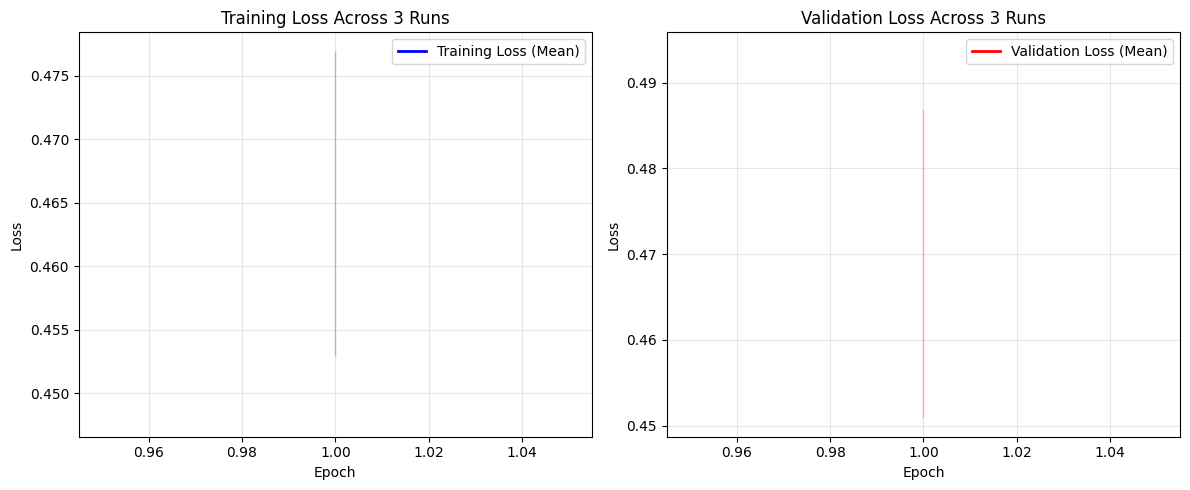

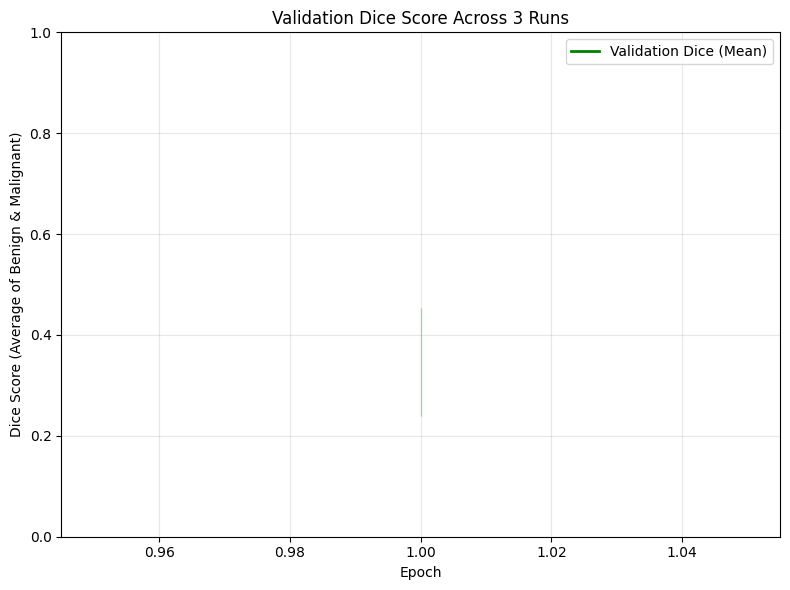

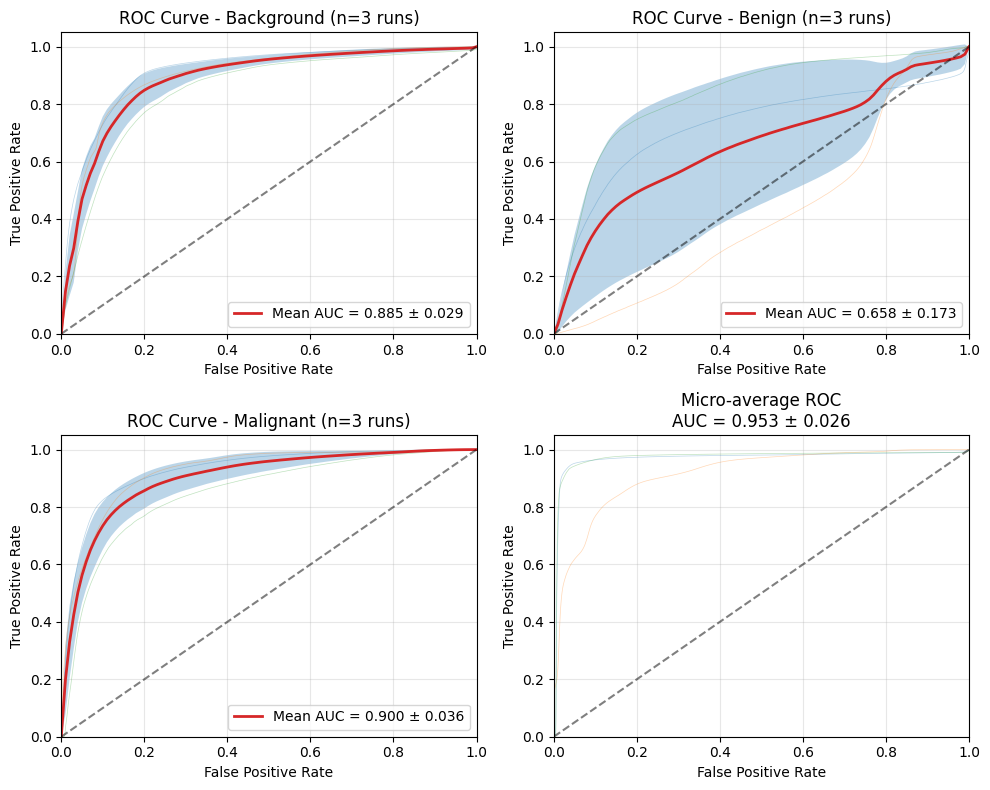

Performing majority voting for confusion matrix...


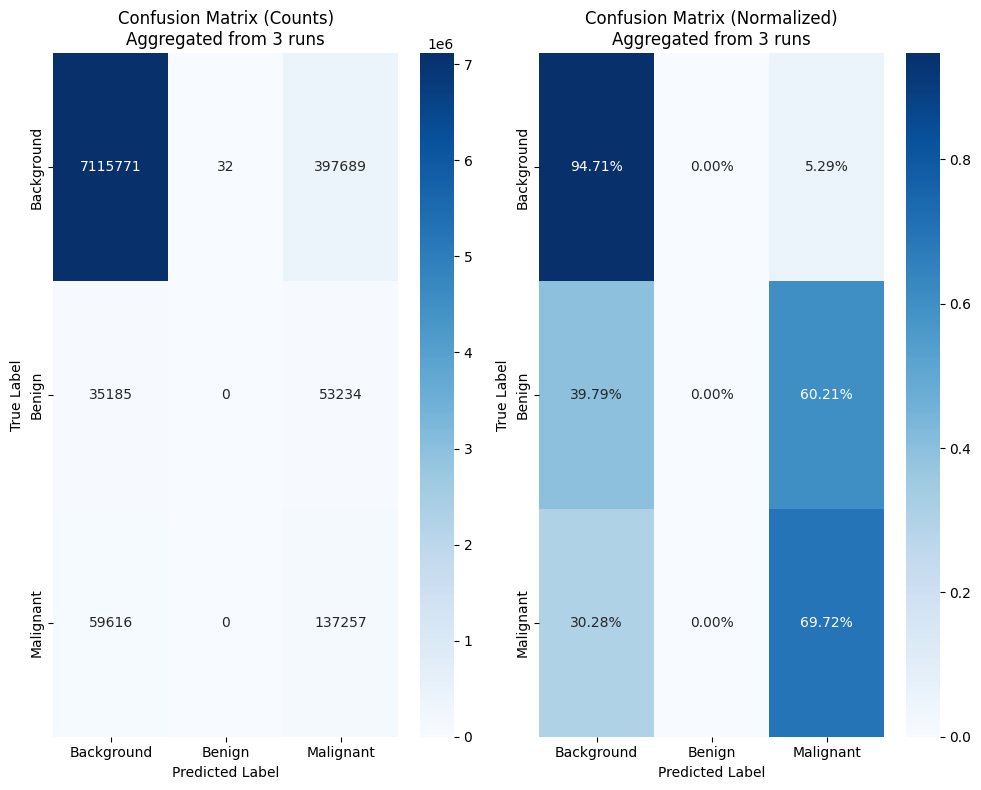


All plots generated and saved!
1. loss_curves.png - Training & Validation Loss
2. dice_curve.png - Validation Dice Score
3. roc_curves.png - ROC Curves for each class
4. confusion_matrix.png - Aggregated Confusion Matrix


AttributeError: 'NoneType' object has no attribute 'keys'

In [ ]:
from collections import defaultdict
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

num_runs = 3  # Number of independent runs
results_uclm = []
results_busi = []
results_datasetb2 = []
num_epochs = 1
patience = 20
epsilon = 1e-7

# =================== NEW: Storage for all runs ===================
# Store training/validation metrics for each run for curves
all_runs_train_loss = []  # Will store train_loss for each epoch for each run
all_runs_val_loss = []    # Will store val_loss for each epoch for each run
all_runs_val_dice = []    # Will store validation Dice scores for each epoch for each run

# Store test set predictions and labels for ROC and confusion matrix
all_runs_test_probs = []  # Store probability outputs for each run
all_runs_test_labels = [] # Store ground truth labels for each run
all_runs_test_preds = []  # Store predicted labels for each run
# ================================================================

for run in range(num_runs):
    print(f"\n{'='*50}")
    print(f"Starting Run {run+1}/{num_runs}")
    print(f"{'='*50}")

    # Reinitialize model for each run (important!)
    model = FinalFunc(num_classes=3).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    # ========= NEW: Initialize storage for this run =========
    run_train_losses = []
    run_val_losses = []
    run_val_dice_cls1 = []  # For benign class
    run_val_dice_cls2 = []  # For malignant class
    # =======================================================

    epoch_metrics_list = []
    best_val_loss = float('inf')
    save_path = 'best_model.pth'
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # -------- Training --------
        model.train()
        train_loss = 0.0
        for imgs, masks in train_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = precision_focused_loss(
                outputs,
                masks,
                ce_weights=ce_weights,
                alpha=0.25,
                gamma=min(2.0, 1.0 + epoch/20)
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Store training loss for this epoch
        run_train_losses.append(train_loss)

        # -------- Validation --------
        model.eval()
        val_loss = 0.0
        val_metrics_sum = defaultdict(float)
        num_val_samples = 0

        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs = imgs.to(device)
                masks = masks.to(device)
                outputs = model(imgs)
                loss = precision_focused_loss(
                    outputs,
                    masks,
                    ce_weights=ce_weights,
                    alpha=0.25,
                    gamma=min(2.0, 1.0 + epoch/20)
                )
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                preds_np = preds.cpu().numpy()

                if masks.device != torch.device('cpu'):
                    masks_np = masks.cpu().numpy()
                else:
                    masks_np = masks.numpy()

                batch_size = preds_np.shape[0]
                num_val_samples += batch_size

                for i in range(batch_size):
                    p = preds_np[i]
                    m = masks_np[i]
                    m_metrics = compute_metrics(p, m)
                    for k, v in m_metrics.items():
                        val_metrics_sum[k] += v

        val_loss /= len(val_loader)
        scheduler.step()

        # Store validation loss and Dice for this epoch
        run_val_losses.append(val_loss)
        val_metrics = {k: val_metrics_sum[k] / num_val_samples for k in val_metrics_sum}
        run_val_dice_cls1.append(val_metrics['Dice_cls1'])
        run_val_dice_cls2.append(val_metrics['Dice_cls2'])

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            print(f"Saved new best model with validation loss: {val_loss:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                # Pad remaining epochs with last values for consistent length
                remaining_epochs = num_epochs - epoch - 1
                run_train_losses.extend([run_train_losses[-1]] * remaining_epochs)
                run_val_losses.extend([run_val_losses[-1]] * remaining_epochs)
                run_val_dice_cls1.extend([run_val_dice_cls1[-1]] * remaining_epochs)
                run_val_dice_cls2.extend([run_val_dice_cls2[-1]] * remaining_epochs)
                break

        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
        print(f"  Val Dice: cls1 (benign)={val_metrics['Dice_cls1']:.3f}, cls2 (malign)={val_metrics['Dice_cls2']:.3f}")

        epoch_metrics_list.append({
            'train_loss': train_loss,
            'val_loss': val_loss,
            **{k: val_metrics[k] for k in val_metrics}
        })

    # Store metrics for this run
    all_runs_train_loss.append(run_train_losses)
    all_runs_val_loss.append(run_val_losses)

    # For validation Dice, we'll use the average of cls1 and cls2
    run_val_dice_avg = [(d1 + d2) / 2 for d1, d2 in zip(run_val_dice_cls1, run_val_dice_cls2)]
    all_runs_val_dice.append(run_val_dice_avg)

    # -------- NEW: Collect test set predictions for this run --------
    print(f"Collecting test set predictions for Run {run+1}...")

    # Load best model for this run
    model.load_state_dict(torch.load(save_path))
    model.eval()

    # We'll use BUS-UCLM test set for demonstration
    # You can repeat for other datasets as needed
    test_probs = []  # Store probability outputs
    test_labels = [] # Store ground truth
    test_preds = []  # Store predicted labels

    with torch.no_grad():
        for imgs, masks in test_loader_bus_uclm:  # Using your BUS-UCLM test loader
            imgs = imgs.to(device)
            outputs = model(imgs)

            # Get probability outputs (softmax)
            probs = F.softmax(outputs, dim=1)  # Shape: [B, C, H, W]

            # Get predicted labels
            preds = torch.argmax(outputs, dim=1)  # Shape: [B, H, W]

            test_probs.append(probs.cpu().numpy())
            test_preds.append(preds.cpu().numpy())

            if masks.device != torch.device('cpu'):
                test_labels.append(masks.cpu().numpy())
            else:
                test_labels.append(masks.numpy())

    # Concatenate all batches
    test_probs = np.concatenate(test_probs, axis=0)
    test_preds = np.concatenate(test_preds, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # Store for this run
    all_runs_test_probs.append(test_probs)
    all_runs_test_labels.append(test_labels)
    all_runs_test_preds.append(test_preds)
    # --------------------------------------------------------------

    # Evaluate on datasets (your existing code)
    uclm_metrics = evaluate_dataset(model, test_loader_bus_uclm, "BUS-UCLM", device)
    busi_metrics = evaluate_dataset(model, test_loader_busi, "BUSI", device)
    datasetb2_path = '/content/drive/MyDrive/DatasetB2'
    datasetb2_metrics = evaluate_datasetb2(model, device, datasetb2_path)

    results_uclm.append(uclm_metrics)
    results_busi.append(busi_metrics)
    results_datasetb2.append(datasetb2_metrics)

# =================== NEW: Generate Plots ===================
print("\n" + "="*50)
print("Generating Plots...")
print("="*50)

# 1. LOSS CURVES (Training and Validation)
plt.figure(figsize=(12, 5))

# Convert to numpy arrays for easier manipulation
train_loss_array = np.array(all_runs_train_loss)  # Shape: [3, num_epochs]
val_loss_array = np.array(all_runs_val_loss)      # Shape: [3, num_epochs]

# Calculate mean and std across runs
train_loss_mean = np.mean(train_loss_array, axis=0)
train_loss_std = np.std(train_loss_array, axis=0)
val_loss_mean = np.mean(val_loss_array, axis=0)
val_loss_std = np.std(val_loss_array, axis=0)

epochs = np.arange(1, len(train_loss_mean) + 1)

plt.subplot(1, 2, 1)
# Plot individual runs (faint lines)
for i in range(num_runs):
    plt.plot(epochs, train_loss_array[i], alpha=0.3, linewidth=0.5, color='blue')
# Plot mean with std
plt.plot(epochs, train_loss_mean, 'b-', label='Training Loss (Mean)', linewidth=2)
plt.fill_between(epochs,
                 train_loss_mean - train_loss_std,
                 train_loss_mean + train_loss_std,
                 alpha=0.3, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Across 3 Runs')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Plot individual runs (faint lines)
for i in range(num_runs):
    plt.plot(epochs, val_loss_array[i], alpha=0.3, linewidth=0.5, color='red')
# Plot mean with std
plt.plot(epochs, val_loss_mean, 'r-', label='Validation Loss (Mean)', linewidth=2)
plt.fill_between(epochs,
                 val_loss_mean - val_loss_std,
                 val_loss_mean + val_loss_std,
                 alpha=0.3, color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Across 3 Runs')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. ACCURACY/DICE CURVE (Validation)
plt.figure(figsize=(8, 6))

val_dice_array = np.array(all_runs_val_dice)  # Shape: [3, num_epochs]
val_dice_mean = np.mean(val_dice_array, axis=0)
val_dice_std = np.std(val_dice_array, axis=0)

# Plot individual runs (faint lines)
for i in range(num_runs):
    plt.plot(epochs, val_dice_array[i], alpha=0.3, linewidth=0.5, color='green')

# Plot mean with std
plt.plot(epochs, val_dice_mean, 'g-', label='Validation Dice (Mean)', linewidth=2)
plt.fill_between(epochs,
                 val_dice_mean - val_dice_std,
                 val_dice_mean + val_dice_std,
                 alpha=0.3, color='green')

plt.xlabel('Epoch')
plt.ylabel('Dice Score (Average of Benign & Malignant)')
plt.title('Validation Dice Score Across 3 Runs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('dice_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. ROC CURVE (Test Set)
plt.figure(figsize=(10, 8))

# Flatten all predictions and labels for ROC calculation
# We'll do one-vs-rest for multi-class
all_probs_flat = []  # Will store probabilities for each class
all_labels_flat = [] # Will store binarized labels
all_fpr = []  # Store FPR for each run and class
all_tpr = []  # Store TPR for each run and class
all_auc = []  # Store AUC for each run and class

# Class names for legend
class_names = ['Background', 'Benign', 'Malignant']

# For each class, compute ROC across runs
for class_idx in range(3):
    plt.subplot(2, 2, class_idx + 1)

    # Store ROC data for this class across runs
    class_fprs = []
    class_tprs = []
    class_aucs = []

    # Base FPR points for interpolation
    base_fpr = np.linspace(0, 1, 101)

    for run_idx in range(num_runs):
        # Get predictions for this run
        probs_run = all_runs_test_probs[run_idx]  # Shape: [N, C, H, W]
        labels_run = all_runs_test_labels[run_idx]  # Shape: [N, H, W]

        # Flatten spatial dimensions
        probs_flat = probs_run[:, class_idx, :, :].flatten()  # Probability for this class
        labels_flat = (labels_run == class_idx).flatten().astype(int)  # Binary labels for this class

        # Compute ROC for this run
        fpr, tpr, _ = roc_curve(labels_flat, probs_flat)
        roc_auc = auc(fpr, tpr)

        # Interpolate to common FPR points
        interp_tpr = np.interp(base_fpr, fpr, tpr)
        interp_tpr[0] = 0.0

        class_fprs.append(base_fpr)
        class_tprs.append(interp_tpr)
        class_aucs.append(roc_auc)

        # Plot individual run (faint line)
        plt.plot(fpr, tpr, alpha=0.3, linewidth=0.5)

    # Convert to arrays
    class_tprs = np.array(class_tprs)  # Shape: [3, 101]
    class_aucs = np.array(class_aucs)

    # Compute mean and std
    mean_tpr = np.mean(class_tprs, axis=0)
    std_tpr = np.std(class_tprs, axis=0)
    mean_auc = np.mean(class_aucs)
    std_auc = np.std(class_aucs)

    # Plot mean ROC with std shading
    plt.plot(base_fpr, mean_tpr, linewidth=2,
             label=f'Mean AUC = {mean_auc:.3f} ± {std_auc:.3f}')
    plt.fill_between(base_fpr,
                     mean_tpr - std_tpr,
                     mean_tpr + std_tpr,
                     alpha=0.3)

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {class_names[class_idx]} (n={num_runs} runs)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

# Add overall macro-average ROC in 4th subplot
plt.subplot(2, 2, 4)
all_mean_aucs = []

# Compute macro-average ROC
for run_idx in range(num_runs):
    probs_run = all_runs_test_probs[run_idx]
    labels_run = all_runs_test_labels[run_idx]

    # Binarize labels for multi-class ROC
    labels_flat = labels_run.flatten()
    labels_bin = label_binarize(labels_flat, classes=[0, 1, 2])

    # Flatten probabilities
    probs_flat = probs_run.transpose(0, 2, 3, 1).reshape(-1, 3)  # Shape: [N*H*W, 3]

    # Compute micro-average ROC
    fpr, tpr, _ = roc_curve(labels_bin.ravel(), probs_flat.ravel())
    roc_auc = auc(fpr, tpr)
    all_mean_aucs.append(roc_auc)

    plt.plot(fpr, tpr, alpha=0.3, linewidth=0.5)

# Compute mean of AUCs
mean_overall_auc = np.mean(all_mean_aucs)
std_overall_auc = np.std(all_mean_aucs)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Micro-average ROC\nAUC = {mean_overall_auc:.3f} ± {std_overall_auc:.3f}')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. CONFUSION MATRIX (Aggregated from 3 runs)
plt.figure(figsize=(10, 8))

# Stack predictions from all 3 runs
# all_runs_test_preds is list of 3 arrays, each shape [N, H, W]
stacked_preds = np.stack(all_runs_test_preds, axis=0)  # Shape: [3, N, H, W]

# Get ground truth (same for all runs, use first run)
ground_truth = all_runs_test_labels[0]  # Shape: [N, H, W]

# Initialize arrays for majority voting
N, H, W = ground_truth.shape
majority_preds = np.zeros((N, H, W), dtype=int)

# Perform majority voting per pixel
print("Performing majority voting for confusion matrix...")
for n in range(N):
    for i in range(H):
        for j in range(W):
            # Get votes from 3 runs for this pixel
            votes = stacked_preds[:, n, i, j]
            # Find majority vote (if tie, choose the higher class)
            counts = np.bincount(votes, minlength=3)
            max_count = np.max(counts)
            # If there's a tie, choose the class with highest index
            if np.sum(counts == max_count) > 1:
                majority_preds[n, i, j] = np.where(counts == max_count)[0][-1]
            else:
                majority_preds[n, i, j] = np.argmax(counts)

# Flatten for confusion matrix
y_true = ground_truth.flatten()
y_pred = majority_preds.flatten()

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

# Normalize by row (true classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Plot confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Counts)\nAggregated from 3 runs')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized)\nAggregated from 3 runs')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAll plots generated and saved!")
print("1. loss_curves.png - Training & Validation Loss")
print("2. dice_curve.png - Validation Dice Score")
print("3. roc_curves.png - ROC Curves for each class")
print("4. confusion_matrix.png - Aggregated Confusion Matrix")
# Function to compute mean and standard deviation across runs
def compute_stats(results_list, dataset_name):
    """Compute mean and standard deviation for all metrics across runs"""
    # Get all metric names from the first run
    metric_names = list(results_list[0].keys())

    stats = {}
    for metric in metric_names:
        values = [run[metric] for run in results_list]
        # Handle NaN values by filtering them out
        valid_values = [v for v in values if not np.isnan(v)]

        if len(valid_values) > 0:
            stats[f'{metric}_mean'] = np.mean(valid_values)
            stats[f'{metric}_std'] = np.std(valid_values, ddof=1)  # Sample std deviation
            stats[f'{metric}_runs'] = len(valid_values)
        else:
            stats[f'{metric}_mean'] = np.nan
            stats[f'{metric}_std'] = np.nan
            stats[f'{metric}_runs'] = 0

    return stats

# Compute statistics for both datasets
uclm_stats = compute_stats(results_uclm, "BUS-UCLM")
busi_stats = compute_stats(results_busi, "BUSI")
datasetb2_stats = compute_stats(results_datasetb2, "DatasetB2 (UDIAT)")

def print_summary_table(uclm_stats, busi_stats, datasetb2_stats):
    print(f"\n{'='*80}")
    print(f"SUMMARY TABLE - Key Metrics Across All Datasets (Mean ± Std)")
    print(f"{'='*80}")

    # include Dice_cls0 (background) here
    key_metrics = [
        'Accuracy', 'Macro_F1', 'Lesion_Avg_Dice',
        'Dice_cls0', 'Dice_cls1', 'Dice_cls2', 'Lesion_F1'
    ]

    # nicer column headings
    print(f"{'Metric':<25} {'BUS-UCLM':<22} {'BUSI':<22} {'DatasetB2':<22}")
    print(f"{'-'*90}")

    for metric in key_metrics:
        # get mean and std; fall back to np.nan if missing
        u_mean = uclm_stats.get(f'{metric}_mean', np.nan)
        u_std  = uclm_stats.get(f'{metric}_std', np.nan)

        b_mean = busi_stats.get(f'{metric}_mean', np.nan)
        b_std  = busi_stats.get(f'{metric}_std', np.nan)

        d_mean = datasetb2_stats.get(f'{metric}_mean', np.nan)
        d_std  = datasetb2_stats.get(f'{metric}_std', np.nan)

        # format safely (shows nan if missing)
        def fmt(mean, std):
            if np.isnan(mean) or np.isnan(std):
                return "nan ± nan"
            return f"{mean:.4f} ± {std:.4f}"

        print(f"{metric:<25} {fmt(u_mean, u_std):<22} {fmt(b_mean, b_std):<22} {fmt(d_mean, d_std):<22}")


print_summary_table(uclm_stats, busi_stats, datasetb2_stats)

# Optional: Save results to file
import json
results_dict = {
    'uclm_stats': uclm_stats,
    'busi_stats': busi_stats,
    'datasetb2_stats': datasetb2_stats,
    'raw_uclm': results_uclm,
    'raw_busi': results_busi,
    'raw_datasetb2': results_datasetb2
}

with open('multiple_run_results.json', 'w') as f:
    # Convert numpy values to Python types for JSON serialization
    json_results = {}
    for key, value in results_dict.items():
        if isinstance(value, list):
            json_results[key] = [
                {k: (float(v) if isinstance(v, (np.floating, np.integer)) else v)
                 for k, v in item.items()}
                for item in value
            ]
        else:
            json_results[key] = {k: (float(v) if isinstance(v, (np.floating, np.integer)) else v)
                               for k, v in value.items()}

    json.dump(json_results, f, indent=2)

print(f"\nResults saved to 'multiple_run_results.json'")


In [ ]:
import numpy as np
import torch

# ---------- Denormalize ----------
def denormalize(img_tensor, mean=None, std=None, clip=True):
    """
    Inverse of normalization.
    img_tensor: torch.Tensor (C,H,W) or (B,C,H,W). CPU or CUDA.
    mean/std: sequence of length C. Defaults to ImageNet normalization.
    Returns tensor in range [0,1] (float32) with shape (C,H,W).
    """
    # default to ImageNet stats (change if your dataset used different values)
    if mean is None:
        mean = [0.485, 0.456, 0.406]
    if std is None:
        std = [0.229, 0.224, 0.225]

    # ensure tensor
    t = img_tensor.clone()
    # if batch, take first sample
    if t.dim() == 4:
        t = t[0]
    # move to cpu and float
    t = t.detach().cpu().float()
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    t = t * std + mean
    if clip:
        t = t.clamp(0.0, 1.0)
    return t  # float tensor in [0,1], shape (C,H,W)

# ---------- Class index -> RGB ----------
def class_idx_to_rgb(mask_idx, palette=None):
    """
    Convert integer mask (H,W) with class indices [0..K-1] to RGB uint8 image (H,W,3).
    palette: dict {class_idx: (R,G,B)} with 0..255 ints.
    Default for 3 classes: 0=black, 1=green, 2=red.
    """
    if palette is None:
        palette = {
            0: (0, 0, 0),       # background - black
            1: (0, 255, 0),     # benign - green
            2: (255, 0, 0)      # malignant - red
        }
    mask = np.array(mask_idx, dtype=np.int32)
    h, w = mask.shape
    out = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in palette.items():
        out[mask == cls] = color
    return out

# ---------- Optional: RGB color map -> indices ----------
def rgb_to_index(rgb_mask, palette=None):
    """
    Convert an RGB mask (H,W,3) with colors matching palette to integer indices.
    Returns (H,W) int array. Useful if GT masks are saved as RGB color images.
    """
    if palette is None:
        palette = {
            0: (0, 0, 0),
            1: (0, 255, 0),
            2: (255, 0, 0)
        }
    rgb = np.asarray(rgb_mask, dtype=np.uint8)
    h, w, _ = rgb.shape
    idx_mask = np.zeros((h, w), dtype=np.int32)
    for cls, color in palette.items():
        matches = np.all(rgb == np.array(color, dtype=np.uint8).reshape(1, 1, 3), axis=2)
        idx_mask[matches] = cls
    return idx_mask


In [ ]:


import random
import numpy as np
import torch
import matplotlib.pyplot as plt

# ensure these are imported earlier in your notebook
# from your code: denormalize, class_idx_to_rgb already defined

# pick dataset to sample from
ds = test_ds_busi

# safety checks
assert hasattr(ds, '__len__'), "Dataset missing __len__"
if len(ds) == 0:
    raise RuntimeError("Dataset has zero length!")

# choose up to 3 random unique indices from the correct dataset length
n_samples = min(3, len(ds))
indices = random.sample(range(len(ds)), n_samples)

model.eval()
for idx in indices:
    # Fetch image and mask from the same dataset (ds)
    img_t, mask_t = ds[idx]  # img_t: tensor [3, H, W], mask_t: tensor [H, W] (expected)

    # forward (handle tuple output)
    with torch.no_grad():
        out = model(img_t.unsqueeze(0).to(device))
        # if model returns (seg_logits, ds_outputs) or similar, take the first element
        if isinstance(out, (tuple, list)):
            seg_logits = out[0]
        else:
            seg_logits = out

        # seg_logits shape: [1, C, H, W]
        pred = torch.argmax(seg_logits, dim=1).cpu().squeeze(0).numpy()  # [H, W]

    # Denormalize (call on CPU tensor; denormalize works with CPU device too)
    img_denorm = denormalize(img_t).cpu()   # denormalize expects a Tensor (CPU or device)
    img_np = img_denorm.permute(1, 2, 0).numpy()

    # Ensure mask numpy shape is HxW with integer class indices
    if isinstance(mask_t, torch.Tensor):
        mask_np = mask_t.cpu().numpy()
    else:
        mask_np = np.array(mask_t)

    # Optional: if your mask is RGB you may need to convert color->class index here
    # e.g. mask_idx = rgb_to_index(mask_np)  # implement if required

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img_np)
    axes[0].set_title(f'Original idx={idx}')
    axes[0].axis('off')

    axes[1].imshow(class_idx_to_rgb(mask_np))
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    axes[2].imshow(img_np)
    axes[2].imshow(class_idx_to_rgb(pred), alpha=0.5)
    axes[2].set_title('Predicted Overlay')
    axes[2].axis('off')

    plt.show()
